# Plant Seedlings Classification/Second experiment


### Mounting drive and setting the environment




Please take into account that the dataset was uploaded into Google Drive.

The following code will authorize access to Google Drive and retrieve the dataset file. Upon successful, the google drive wil be mounted to the colab as /content/gdrive.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

KeyboardInterrupt: ignored

Execute some basic linux terminal commands for checking if the dataset is uploaded in Google Drive.

In [0]:
! ls "/content/gdrive/train"

Check if the code is using GPU

In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import os, shutil for use functions for many operating system related functions 

In [0]:
import os, shutil
from random import shuffle

Define some environment constants and create directories to store validation and training set for each classes

In [0]:
# path to original dataset
original_dataset_dir = '/content/gdrive/My Drive/train'
# directory to store the smaller dataset
base_dir = '/content/gdrive/My Drive/curated' 

#os.mkdir(base_dir)

In [0]:
# make training, validation and test set directories
train_dir = os.path.join(base_dir, 'train')
#os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
#os.mkdir(validation_dir)

In [0]:
classes = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
           'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']

In [0]:
for directory in [train_dir, validation_dir]:
    for clas in classes:
        clas_dir = os.path.join(directory, clas)
        #os.mkdir(clas_dir)

In [0]:
for clas in classes:
    print(clas, ": ", len(os.listdir(os.path.join(original_dataset_dir, clas))))

Black-grass :  263
Charlock :  390
Cleavers :  287
Common Chickweed :  611
Common wheat :  221
Fat Hen :  475
Loose Silky-bent :  654
Maize :  221
Scentless Mayweed :  516
Shepherds Purse :  231
Small-flowered Cranesbill :  496
Sugar beet :  385


### Prepare the dataset




Split the training data set in validation and training set

During training of the model, we constantly check the accuracy and loss by taking a small sample of training data for comparing the prediction of the model under training and the respective ground truths. This help us keep track on the accuracy of the model as training progresses and check if the model is overfitting / underfitting. Such small subset of data taken from the training data is commonly known as "validation data / set".

Training set - 70%

Validation set - 30%

In [0]:
#rate = 0.3
#for clas in classes:
    #clas_dir = os.path.join(directory, clas)
    #original_directory = os.path.join(original_dataset_dir, clas)
    

    # list of all the images in the current class directory
    #files = os.listdir(original_directory)
    #num_of_val_images = int(rate * len(files))
    # randomly shuffle the list
    #shuffle(files)
    
    #val_files = files[:num_of_val_images]
    #trn_files = files[num_of_val_images:]
    
    #for index, fnames in enumerate([trn_files, val_files]):
        #folder = train_dir if index == 0 else validation_dir
        #destination_dir = os.path.join(folder, clas)
        
        #for fname in fnames:
            #src = os.path.join(original_directory, fname)
            #dst = os.path.join(destination_dir, fname)
            #shutil.copyfile(src, dst)  
            
        #if index == 0:
            #print(clas, "--> Training:  ", len(os.listdir(destination_dir)))
        #else: 
            #print(clas, "--> Validation:  ", len(os.listdir(destination_dir)))

Import necessary packages

In [0]:
%matplotlib inline

The future statement is intended to ease migration to future versions of Python

In [0]:
from __future__ import print_function, division

Time module allow to handle various operations regarding time. Module Copy is required because assignment statements do not copy objects directly. Numpy is for supporting multi-dimensional arrays along with a large collection of functions. An alias for the namespace will be created.pyplot is matplotlib's plotting framework



In [0]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

torch package provides tensor computation with strong GPU acceleration.torch.nn contains different classess that help you build neural network models.torch.optim is a package implementing various optimization algorithms

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

torchvision package consists of common image transformations for computer vision

In [0]:
import torchvision
from torchvision import transforms, datasets, models

 turns on interactive plotting

In [0]:
plt.ion()

A common strategy for training neural networks is to introduce randomness in the input data itself. We can randomly rotate, mirror, scale, and/or crop images during training. This will help the network generalize as it's seeing the same images but in different locations, with different sizes, in different orientations.

transforms.Compose just clubs all the transforms provided to it. So, all the transforms in the transforms

transforms.RandomResizedCrop(224): This will extract a patch of size (224, 224) from your input image randomly

transforms.RandomHorizontalFlip(): 50-50 chance that the image will be flipped horizontally

transforms.ToTensor():convert the images to PyTorch tensors 

transforms.Normalize():helps get data within a range and reduces the skewness which helps learn faster and better

transforms.Resize(256):Resize the images 

transforms.CenterCrop(224): Crops the center of the image so it is a 224 pixels by 224 pixels square image.

In [0]:
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.3200, 0.2880, 0.1953], [0.0840, 0.0874, 0.0952])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.3200, 0.2880, 0.1953], [0.0840, 0.0874, 0.0952])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.3200, 0.2880, 0.1953], [0.0840, 0.0874, 0.0952])
    ])
}

NameError: ignored

In [0]:
path = '/content/gdrive/My Drive/curated/'

Load in each dataset and apply transformations using the torchvision.datasets as datasets library

In [0]:
image_datasets = {x: datasets.ImageFolder(os.path.join(path, x), transform[x]) 
                  for x in ['train', 'validation', 'test']}

The DataLoader takes a dataset and returns batches of images and the corresponding labels.It is usually convenient to package a Dataset in a DataLoader. The DataLoader is the most common interface for offering data to a training loop.

In [0]:
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'validation', 'test']}

Getting training and validation dataset size

In [0]:
nb_images = {x: len(image_datasets[x]) for x in ['train', 'validation']}
nb_images

{'train': 3330, 'validation': 1420}

Printing class names

In [0]:
class_names = image_datasets['train'].classes
class_names

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

Getting mean and std to normalization

In [0]:
mean = 0.
std = 0.

for images, labels in data_loaders['train']:
    images, labels = images.to(device), labels.to(device)
    
    # get number of images in the batch and number of channels
    batch_size = images.size(0)
    nb_channels = images.size(1)
    
    # flatten height and width into one axis
    images = images.view(batch_size, nb_channels, -1)
    # get mean and std
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    
mean /= nb_images['train']
std /= nb_images['train']

print('mean: ', mean)
print('std: ', std)

mean:  tensor([-0.0040, -0.0056, -0.0096], device='cuda:0')
std:  tensor([0.9912, 0.9928, 0.9915], device='cuda:0')


In [0]:
def imshow(inp, title=None):
    # convert to numpy array and transpose
    inp = inp.numpy().transpose([1, 2, 0])
    # mean and std used for normalization
    mean = np.asarray([0.3200, 0.2880, 0.1953])
    std = np.asarray([0.0840, 0.0874, 0.0952])
    # unnormalize
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

Make a grid of images

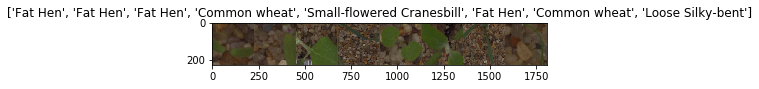

In [0]:
train_iter = iter(data_loaders['train'])
images, labels = train_iter.next()

grid = torchvision.utils.make_grid(images)
title = [class_names[x] for x in labels]

imshow(grid, title=title)

###Model Building

All models need to be trained on a lot of data to be effective. Instead of random initialization, we initialize the network with a pretrained model, that is, a model created by some one else to solve a different problem. We'll use a model trained on ImageNet (1.2 million images and 1000 classes). The model is a Convolutional Neural Network (CNN) resnet34
  

In [0]:
def train(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        # each epoch has a training and a validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
                scheduler.step()
            else:
                model.eval()
            
            running_loss = 0.
            running_corrects = 0.
            for images, labels in data_loaders[phase]:
                images, labels = images.to(device), labels.to(device)
                # zero the gradient buffer
                optimizer.zero_grad()
                # forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)

                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # stats
                running_loss += loss.item() * labels.size(0)
                running_corrects += (preds == labels).sum().item()

            epoch_loss = running_loss / nb_images[phase]
            epoch_acc = running_corrects / nb_images[phase]

            print('{} Loss: {:.4f}  Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'validation' and epoch_acc > best_acc:
                best_model_wts = copy.deepcopy(model.state_dict())
                best_acc = epoch_acc

        print()
    
    time_elapsed = time.time() - since
    print('Training complete in: {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best validation acc: {:.4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model 

Generic function for visualizing the model predictions

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    images_so_far = 0
    model.eval()
    fig = plt.figure()
    
    with torch.no_grad():
        for images, labels in data_loaders['validation']:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(images.cpu().data[j])
                
            if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Returns a model pre-trained on ImageNet

In [0]:
model = models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:04<00:00, 21.8MB/s]


Turn off training for their parameters

In [0]:
for param in model.parameters():
    param.requires_grad = False

In [0]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

Loss function criterion decides how the output can be compared to a class, which determines how good or bad the neural network performs

In [0]:
criterion = nn.CrossEntropyLoss()

Optimizer select a way to update the weight in order to converge to find the best weights in this neural network.

A smaller learning rate may allow the model to learn a more optimal or even globally optimal set of weights 

In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

The learning rate scheduler adjusts the learning rates stored in the optimizer. A step function is used to lower the learning rate after 7 steps with a multiplicative factor of gamma=0.1.

In [0]:
scheduler = lr_scheduler.StepLR(optimizer, 7, gamma=0.1)

Train 25 epochs

In [0]:
model = train(model, criterion, optimizer, scheduler, num_epochs=25)

Epoch 1/25
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 1.9532  Acc: 0.3480
validation Loss: 1.3790  Acc: 0.5669

Epoch 2/25
----------
train Loss: 1.5184  Acc: 0.5009
validation Loss: 1.1245  Acc: 0.6514

Epoch 3/25
----------
train Loss: 1.3665  Acc: 0.5438
validation Loss: 1.0234  Acc: 0.6718

Epoch 4/25
----------
train Loss: 1.2930  Acc: 0.5601
validation Loss: 0.9531  Acc: 0.6923

Epoch 5/25
----------
train Loss: 1.2558  Acc: 0.5775
validation Loss: 0.8568  Acc: 0.7246

Epoch 6/25
----------
train Loss: 1.2342  Acc: 0.5832
validation Loss: 0.8700  Acc: 0.7155

Epoch 7/25
----------
train Loss: 1.1021  Acc: 0.6405
validation Loss: 0.8338  Acc: 0.7303

Epoch 8/25
----------
train Loss: 1.0879  Acc: 0.6459
validation Loss: 0.8125  Acc: 0.7303

Epoch 9/25
----------
train Loss: 1.1025  Acc: 0.6387
validation Loss: 0.8175  Acc: 0.7324

Epoch 10/25
----------
train Loss: 1.0724  Acc: 0.6474
validation Loss: 0.7931  Acc: 0.7528

Epoch 11/25
----------
train Loss: 1.0922  Acc: 0.6396
validation Loss: 0.7782  Acc: 0.7500

Epoch 12

In [0]:
for param in model.parameters():
    param.requires_grad = True

In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [0]:
model = train(model, criterion, optimizer, scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 1.7644  Acc: 0.4249
validation Loss: 1.3023  Acc: 0.5479

Epoch 2/25
----------
train Loss: 1.1818  Acc: 0.6090
validation Loss: 1.3688  Acc: 0.6754

Epoch 3/25
----------
train Loss: 0.9674  Acc: 0.6775
validation Loss: 0.6370  Acc: 0.7768

Epoch 4/25
----------
train Loss: 0.7973  Acc: 0.7261
validation Loss: 0.5952  Acc: 0.8077

Epoch 5/25
----------
train Loss: 0.7770  Acc: 0.7366
validation Loss: 0.5241  Acc: 0.7901

Epoch 6/25
----------
train Loss: 0.6711  Acc: 0.7721
validation Loss: 0.3195  Acc: 0.8866

Epoch 7/25
----------
train Loss: 0.6406  Acc: 0.7742
validation Loss: 0.3813  Acc: 0.8655

Epoch 8/25
----------
train Loss: 0.6219  Acc: 0.7928
validation Loss: 0.3422  Acc: 0.8831

Epoch 9/25
----------
train Loss: 0.5854  Acc: 0.8078
validation Loss: 0.3499  Acc: 0.8627

Epoch 10/25
----------
train Loss: 0.5727  Acc: 0.8036
validation Loss: 0.5867  Acc: 0.7627

Epoch 11/25
----------
train Loss: 0.5377  Acc: 0.8222
validation Loss: 0.3761 

Custom dataset that includes image file paths

In [0]:
class ImageFolderWithPaths(datasets.ImageFolder):
   
    def __init__(self, path, transform):
        super(ImageFolderWithPaths, self).__init__(path, transform=transform)

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

Instantiate the test dataset and dataloader

In [0]:
test_dataset = ImageFolderWithPaths('/content/gdrive/My Drive/curated/test', transform['test']) # our custom dataset
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

Notify all your layers that you are in eval mode

In [0]:
model = model.eval()

Preparing submission on Kaggle

In [0]:
test_filenames = []
test_predictions = []

In [0]:

for images, labels, paths in test_dataloader:
    images, labels = images.to(device), labels.to(device)
    
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    
    predicted_classes = [class_names[i.item()] for i in preds]
    filenames = [path[25:] for path in paths]
    
    test_filenames.extend(filenames)
    test_predictions.extend(predicted_classes)

In [0]:
len(test_predictions)

794

In [0]:
pathcsv = '/content/gdrive/My Drive/'

import pandas as pd
results=pd.DataFrame({"file":test_filenames,
                      "species":test_predictions})
results.to_csv(pathcsv+"res.csv",index=False)